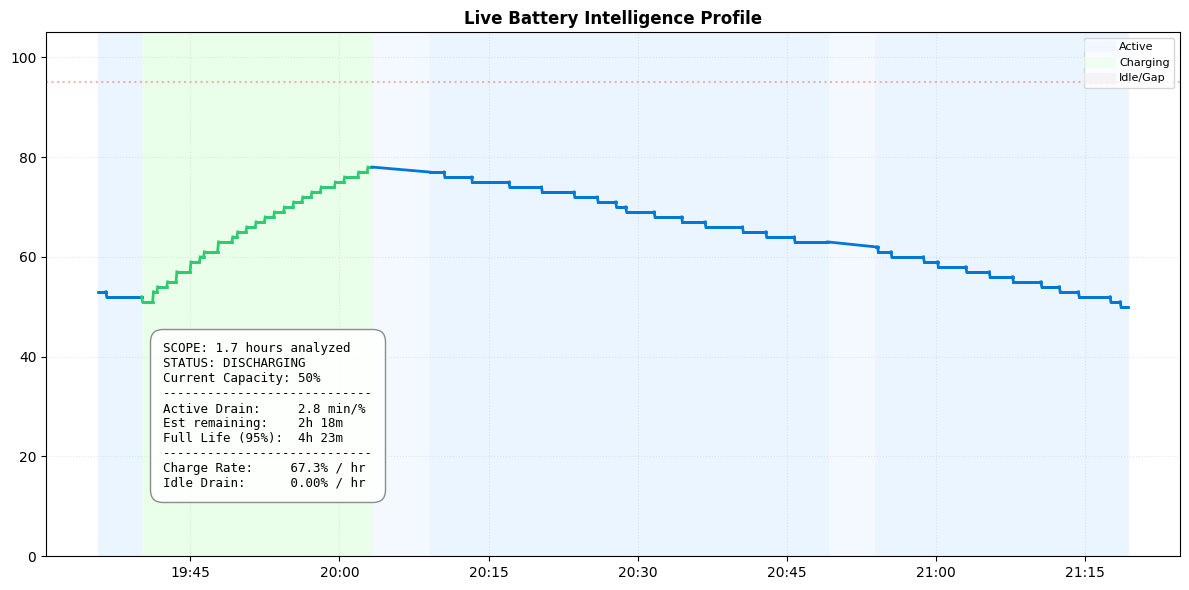

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
import time
from IPython.display import display, clear_output
from matplotlib.lines import Line2D

# --- CONFIGURATION ---
FILE_PATH = Path.home() / "Desktop" / "battery_logger" / "battery_log.csv"
IDLE_THRESHOLD_MINS = 10 
REFERENCE_PCT = 95

def format_time(total_mins):
    if total_mins <= 0 or np.isnan(total_mins):
        return "0h 0m"
    h = int(total_mins // 60)
    m = int(total_mins % 60)
    return f"{h}h {m}m"

while True:
    if FILE_PATH.exists():
        try:
            with open(FILE_PATH, 'r', encoding='utf-8', errors='ignore') as f:
                df = pd.read_csv(f, header=None, names=['A', 'B', 'C'])

            if not df.empty and len(df) > 1:
                # 1. Data Processing
                df['Timestamp'] = pd.to_datetime(df['A'], errors='coerce')
                df['Percentage'] = df['B'].astype(str).str.replace('%', '').astype(float)
                df['Charger'] = df['C'].astype(str).str.strip()
                df = df.dropna(subset=['Timestamp', 'Percentage']).sort_values('Timestamp')

                df['time_delta'] = df['Timestamp'].diff().dt.total_seconds() / 60
                df['pct_delta'] = df['Percentage'].shift(1) - df['Percentage']
                
                # --- NEW: Calculate Total Time Scope ---
                time_span = df['Timestamp'].max() - df['Timestamp'].min()
                total_hours_analyzed = time_span.total_seconds() / 3600

                # 2. Calculations
                active_mask = (df['Charger'] == 'No') & (df['time_delta'] <= IDLE_THRESHOLD_MINS)
                total_active_mins = df.loc[active_mask, 'time_delta'].sum()
                total_active_drop = df.loc[active_mask, 'pct_delta'].sum()
                active_rate = total_active_mins / total_active_drop if total_active_drop > 0 else 0
                
                charge_mask = (df['Charger'] == 'Yes') & (df['time_delta'] <= IDLE_THRESHOLD_MINS)
                total_charge_mins = df.loc[charge_mask, 'time_delta'].sum()
                total_charge_gain = -df.loc[charge_mask, 'pct_delta'].sum()
                charge_rate_hr = (total_charge_gain / (total_charge_mins / 60)) if total_charge_mins > 0 else 0

                idle_mask = (df['time_delta'] > IDLE_THRESHOLD_MINS)
                idle_df = df[idle_mask].copy()
                avg_idle_loss_per_hr = (idle_df['pct_delta'] / (idle_df['time_delta'] / 60)).mean() if not idle_df.empty else 0

                current_pct = df['Percentage'].iloc[-1]
                is_charging = df['Charger'].iloc[-1] == 'Yes'
                
                # Estimates
                endurance_ref_mins = active_rate * REFERENCE_PCT
                current_rem_mins = active_rate * current_pct if not is_charging else 0

                # 3. Plotting logic
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(12, 6))
                
                for i in range(1, len(df)):
                    p1, p2 = df.iloc[i-1], df.iloc[i]
                    start_t, end_t = p1['Timestamp'], p2['Timestamp']
                    
                    if p2['time_delta'] > IDLE_THRESHOLD_MINS:
                        bg_color, line_color, line_style = '#f0f0f0', '#95a5a6', '--'
                    elif p2['Charger'] == 'Yes':
                        bg_color, line_color, line_style = '#eaffea', '#2ecc71', '-'
                    else:
                        bg_color, line_color, line_style = '#ebf5ff', '#0078d7', '-'

                    ax.axvspan(start_t, end_t, color=bg_color, alpha=0.5)
                    ax.plot([start_t, end_t], [p1['Percentage'], p2['Percentage']], 
                            color=line_color, linestyle=line_style, linewidth=2)

                # Legend
                custom_lines = [
                    Line2D([0], [0], color='#ebf5ff', lw=8, alpha=0.6),
                    Line2D([0], [0], color='#eaffea', lw=8, alpha=0.6),
                    Line2D([0], [0], color='#f0f0f0', lw=8, alpha=0.6)
                ]
                ax.legend(custom_lines, ['Active', 'Charging', 'Idle/Gap'], 
                          loc='upper right', fontsize=8, frameon=True)

                # Dashboard Text (Updated with Analysis Scope)
                stats_text = (
                    f"SCOPE: {total_hours_analyzed:.1f} hours analyzed\n"
                    f"STATUS: {'CHARGING' if is_charging else 'DISCHARGING'}\n"
                    f"Current Capacity: {current_pct:.0f}%\n"
                    f"----------------------------\n"
                    f"Active Drain:     {active_rate:.1f} min/%\n"
                    f"Est remaining:    {format_time(current_rem_mins) if not is_charging else 'Charging...'}\n"
                    f"Full Life ({REFERENCE_PCT}%):  {format_time(endurance_ref_mins)}\n"
                    f"----------------------------\n"
                    f"Charge Rate:     {charge_rate_hr:.1f}% / hr\n"
                    f"Idle Drain:      {avg_idle_loss_per_hr:.2f}% / hr"
                )
                
                fig.text(0.14, 0.18, stats_text, fontsize=9, family='monospace',
                         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=1'))

                ax.axhline(REFERENCE_PCT, color='#e74c3c', linestyle=':', alpha=0.4)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                ax.set_ylim(0, 105)
                ax.set_title("Live Battery Intelligence Profile", fontsize=12, fontweight='bold')
                ax.grid(True, which='both', linestyle=':', alpha=0.3)
                
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Update Loop Error: {e}")
            time.sleep(5)
    
    time.sleep(10)